<a href="https://colab.research.google.com/github/liao961120/cilin/blob/main/etc/radical_semantic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install dependencies
!pip install -q CompoTree
!pip install -q cilin
!pip install -q opencc

# Download font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -qo NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

# Download data
!wget -q https://github.com/liao961120/cilin/archive/refs/heads/main.zip
!unzip -q main.zip
!mv cilin-main/etc/* .

     |████████████████████████████████| 1.3 MB 8.7 MB/s 
     |████████████████████████████████| 600 kB 8.3 MB/s 
     |████████████████████████████████| 766 kB 7.6 MB/s 
--2021-12-20 14:00:34--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  33.1MB/s    in 3.5s    

2021-12-20 14:00:38 (33.1 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]



In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager  

# Set chinese font for plotting
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    try:
        font_manager.fontManager.addfont(font_file)
    except: pass
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [4]:
import json
import numpy as np
import pandas as pd
from cilin import Cilin
from CompoTree import Radicals
from collections import Counter
from itertools import product, chain
from random import sample
from utils import *

C = Cilin(trad=True)
def all_words():
    return chain.from_iterable(C.category_split().values())

## 同義詞詞林

<img src="https://github.com/liao961120/cilin/raw/main/etc/cilin_encoding.png" width=59% style="display:inlin-block">

<img src="https://github.com/liao961120/cilin/raw/main/etc/cilin_hierarchy.png" width=40% style="display:inlin-block">


## One-Character Words

### EDA

In [5]:
Tagger = RadicalSemanticTagger(all_words=all_words(), bigram=True, word_type="single")
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)
rows = [f"{x} {C.get_tag(x)}" for x in DTM.documents]
columns = DTM.features
print(DTM.count_mat.shape)
DTM.count_mat

(12, 23)


array([[ 30,  36,  52,   0,  15,   2,   3,  17,   9,   0,   5,   4,   2,
          8,  18,   4,  25,  19,   7,   1,   7,   0,   1],
       [ 92,  17,  12,   9, 117,   4,   3,  69,  79,  12,  33,  49,  15,
         33, 379,  27, 406,  35,  52,   5, 101, 156,  10],
       [ 21,   8,   3,   1,  17,   0,   1,  13,  23,   1,  19,   0,   2,
          7,  21,   3,  64,  13,   1,   1,   7,   2,   1],
       [167,  69,  21,   1,  91,   4,  29,  58,  47,   1,  66,  22,   9,
         31, 123,  34, 191,  50,  24,  12,  56,  34,  13],
       [ 84,  57,  23,   2,  71,   3,  38,  43,  38,   3,  26,  21,   5,
         15,  64,  27, 207,  55,  19,  15,  40,  25,  17],
       [ 31,  16,   1,   0, 224,   3,   3, 101,  18,   2,   4,   9,   3,
         12,  28,  35,  88,  67,  11,   7,  24,   6,   3],
       [ 37,  15,   6,   0,  28,   0,  68,  19,   7,   3,   6,   5,   1,
          3,   9,   2,  96,  15,   5,   4,   3,   3,   1],
       [148,  60,  20,   1, 204,   8,  20,  67,  31,   2,  23,  20,   7,
   

In [6]:
def heatmap(mat):
    if isinstance(mat, np.ndarray):
        dfT = pd.DataFrame(mat, index=rows, columns=columns)
    else:
        dfT = mat
    ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                     annot=True, fmt='.2f', cbar=False,
                     cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
    ax.xaxis.set_label_position('top')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.xlabel("Radical Semantic Type", labelpad=15); plt.ylabel("Word Semantic Type", labelpad=15)
    plt.show()

#### $P(Word~Type|Radical~Type)$

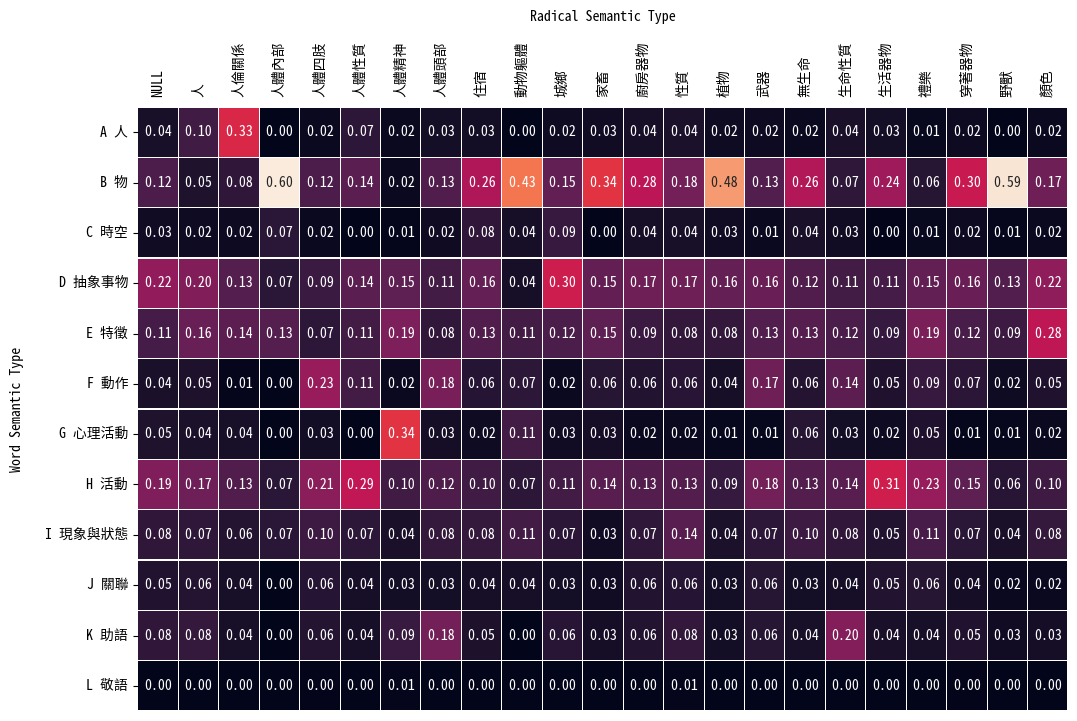

In [7]:
# np.sum(DTM.np, axis=0).shape
plt.figure(figsize=(12, 8), dpi=100)
P_givenFeat = DTM.count_mat / np.sum(DTM.count_mat, axis=0)
heatmap(P_givenFeat)

#### $P(Radical~Type|Word~Type)$

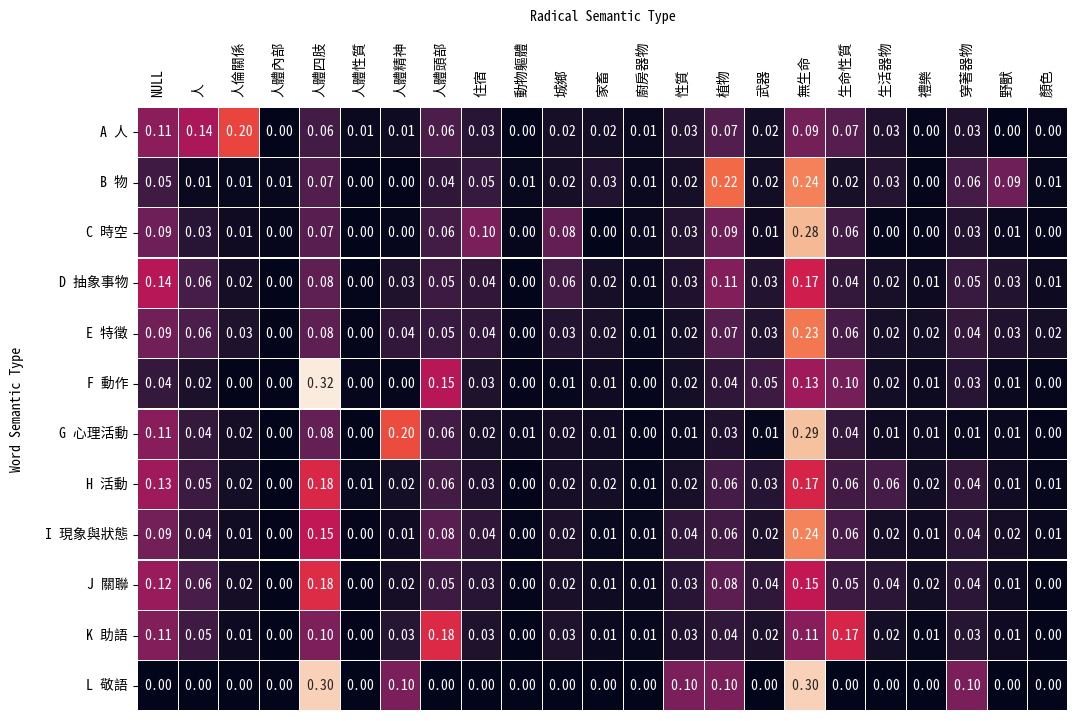

In [8]:
plt.figure(figsize=(12, 8), dpi=100)
P_givenDoc = (DTM.count_mat.T / np.sum(DTM.count_mat, axis=1)).T
heatmap(P_givenDoc)

#### Scatter of the Two condicional Probabilites

In [9]:
df_cond_prob_scatter = []
for i in range(P_givenDoc.shape[0]):
    for j in range(P_givenDoc.shape[1]):
        word, rad = rows[i], columns[j]
        p_rad_given_word = P_givenDoc[i][j]
        p_word_given_rad = P_givenFeat[i][j]
        df_cond_prob_scatter.append(
            (p_rad_given_word, p_word_given_rad, word, rad)
        )
df_cond_prob_scatter = pd.DataFrame(df_cond_prob_scatter, columns="P(r|w) P(w|r) word rad".split())
df_cond_prob_scatter

,P(r|w),P(w|r),word,rad
0,0.113208,0.039164,A 人,NULL
1,0.135849,0.101983,A 人,人
2,0.196226,0.327044,A 人,人倫關係
3,0.000000,0.000000,A 人,人體內部
4,0.056604,0.015337,A 人,人體四肢
...,...,...,...,...
271,0.000000,0.000000,L 敬語,生活器物
272,0.000000,0.000000,L 敬語,禮樂
273,0.100000,0.002924,L 敬語,穿著器物
274,0.000000,0.000000,L 敬語,野獸


In [10]:
import plotly.express as px

df = px.data.iris()
fig = px.scatter(df_cond_prob_scatter, x="P(r|w)", y="P(w|r)", 
                 symbol="rad", color="word",
                 hover_data=['word', 'rad'], width=900, height=700)
fig.update_layout(showlegend=False)
fig.show()

#### Tf-IDF Matrix (single-character words)

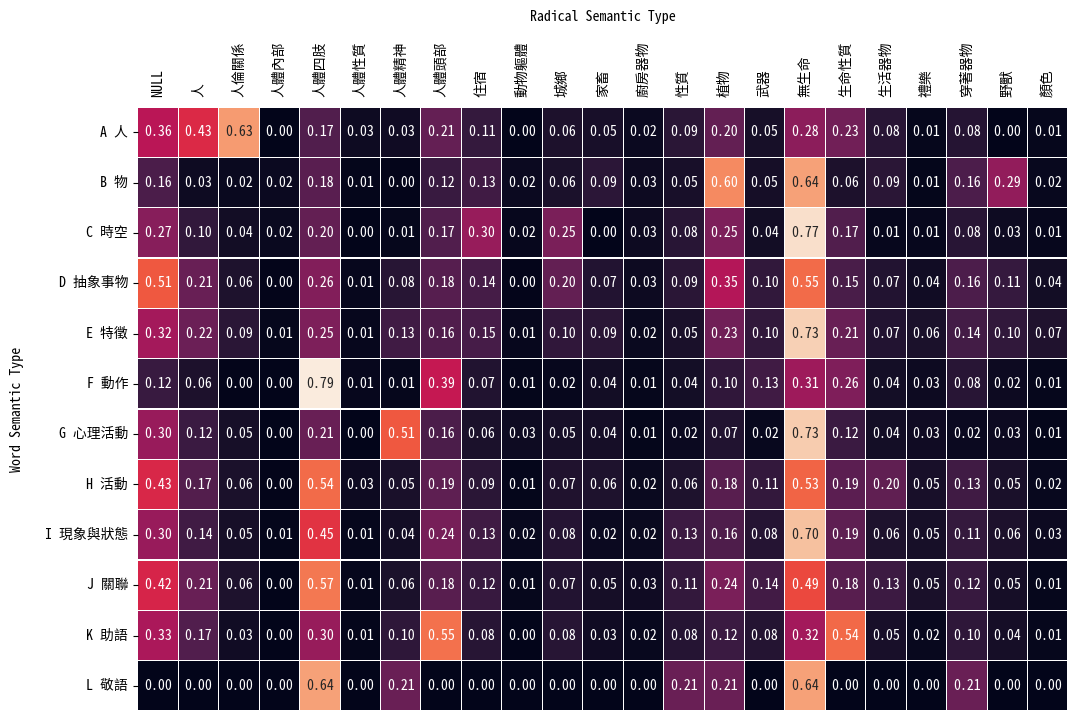

In [11]:
plt.figure(figsize=(12, 8), dpi=100)
P_tfidf = DTM.np
heatmap(P_tfidf)

In [12]:
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)
df_feat, df_tgt = DTM.pd, DTM.df_tgt

In [13]:
pd.DataFrame(DTM.np, index=DTM.documents, columns=DTM.features)

,NULL,人,人倫關係,人體內部,人體四肢,人體性質,人體精神,人體頭部,住宿,動物軀體,城鄉,家畜,廚房器物,性質,植物,武器,無生命,生命性質,生活器物,禮樂,穿著器物,野獸,顏色
Aa01,0.406219,0.308751,0.406144,0.0,0.081704,0.0,0.000000,0.204047,0.449845,0.0,0.000000,0.000000,0.0,0.124908,0.268748,0.000000,0.070207,0.410127,0.251147,0.0,0.000000,0.0,0.0
Aa02,0.228373,0.433944,0.570828,0.0,0.000000,0.0,0.185307,0.430175,0.000000,0.0,0.172835,0.000000,0.0,0.175555,0.000000,0.177763,0.197350,0.288213,0.000000,0.0,0.000000,0.0,0.0
Aa03,0.434502,0.183471,0.000000,0.0,0.000000,0.0,0.470086,0.181878,0.000000,0.0,0.000000,0.270102,0.0,0.000000,0.159700,0.000000,0.625794,0.182784,0.000000,0.0,0.000000,0.0,0.0
Aa04,0.535627,0.678515,0.446274,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.231432,0.000000,0.000000,0.0,0.000000,0.0,0.0
Aa05,0.843837,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.310149,0.437889,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
La02,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
La03,0.000000,0.000000,0.000000,0.0,0.469357,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.717546,0.514618,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
La04,0.000000,0.000000,0.000000,0.0,0.778462,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.334462,0.000000,0.000000,0.0,0.531161,0.0,0.0
La05,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.882661,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.470011,0.000000,0.000000,0.0,0.000000,0.0,0.0


### (Multinomial) Naive Bayes Classifier

In [14]:
from sklearn.naive_bayes import MultinomialNB

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['C 時空', 'F 動作', 'I 現象與狀態', 'J 關聯', 'L 敬語']


,precision,recall,f1-score,support
A 人,0.484848,0.266667,0.344086,60.000000
B 物,0.430000,0.716667,0.537500,120.000000
C 時空,0.000000,0.000000,0.000000,30.000000
D 抽象事物,0.184211,0.080460,0.112000,87.000000
E 特徵,0.291667,0.077778,0.122807,90.000000
F 動作,0.000000,0.000000,0.000000,29.000000
G 心理活動,0.375000,0.136364,0.200000,22.000000
H 活動,0.300505,0.804054,0.437500,148.000000
I 現象與狀態,0.000000,0.000000,0.000000,64.000000
J 關聯,0.000000,0.000000,0.000000,22.000000


#### Permutation Importance: Selecting Important Features

In [15]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, r2_score

# df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': 'f1_weighted',
}
imps = permutation_importance(model, X_test, y_test, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=8, n_jobs=-1, random_state=100)

In [16]:
importances = imps['f1']['importances_mean']
# std = imps['f1']['importances_std']

# model.score(X_test, y_test)
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])

In [17]:
df_importance.sort_values(by="accuracy", ascending=False)

,accuracy,f1,precision,recall
植物,0.033836,0.023417,0.010556,0.033836
無生命,0.028927,0.026594,0.022534,0.028927
人體精神,0.025596,0.025241,0.036136,0.025596
人體四肢,0.025421,0.022537,0.015308,0.025421
野獸,0.021038,0.015233,0.011539,0.021038
人倫關係,0.020337,0.022774,0.013752,0.020337
生命性質,0.013149,0.019268,0.028775,0.013149
人,0.008590,0.009384,0.006787,0.008590
人體頭部,0.008415,0.014061,0.007623,0.008415
人體內部,0.004734,0.003317,0.004455,0.004734


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5]), <a list of 23 Text major ticklabel objects>)

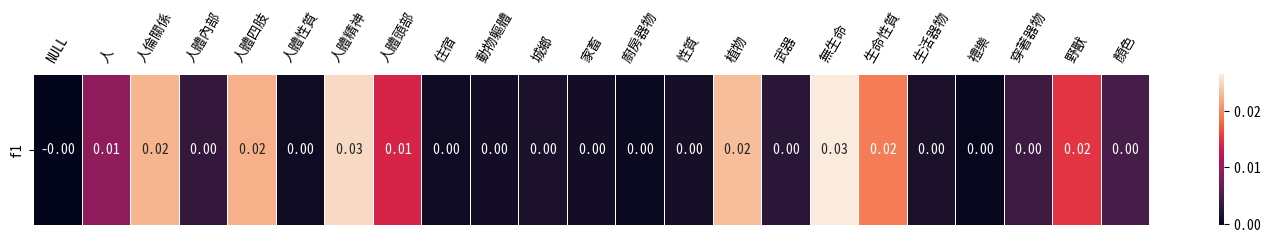

In [18]:
plt.figure(figsize=(18, 2), dpi=100)
sns.heatmap(df_importance[['f1']].T, xticklabels=True, linewidths=0.01, linecolor='white',
            annot=True, fmt='.2f', 
            cbar_kws=dict(orientation='vertical', aspect=35, pad=0.05))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                bottom=False, top = False, labeltop=True)
plt.xticks(rotation=60)

In [19]:
df_importance_selected = df_importance.copy()

#### Feature importance of each class

In [20]:
from copy import deepcopy

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [21]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

scoreDiff = {}
rmFeat = []
for col in df_importance_selected.index:
    # X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    # Shuffle
    X_train_drop, X_test_drop = X_train.copy(deep=True), X_test.copy(deep=True)
    X_train_drop[col] = X_train_drop[col].sample(frac=1, random_state=100).values
    X_test_drop[col] = X_test_drop[col].sample(frac=1, random_state=100).values
    # df1['HS_FIRST_NAME'] = df[4].sample(frac=1).values

    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            continue
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(baseScore['accuracy']- val)
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                k = f"{cls}_{stat}"
                if any(x in k for x in 'support macro weighted'.split()): continue
                if "f1" not in k: continue  # use F1 score only
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(base_val - val)

df = pd.DataFrame(scoreDiff, index=rmFeat)

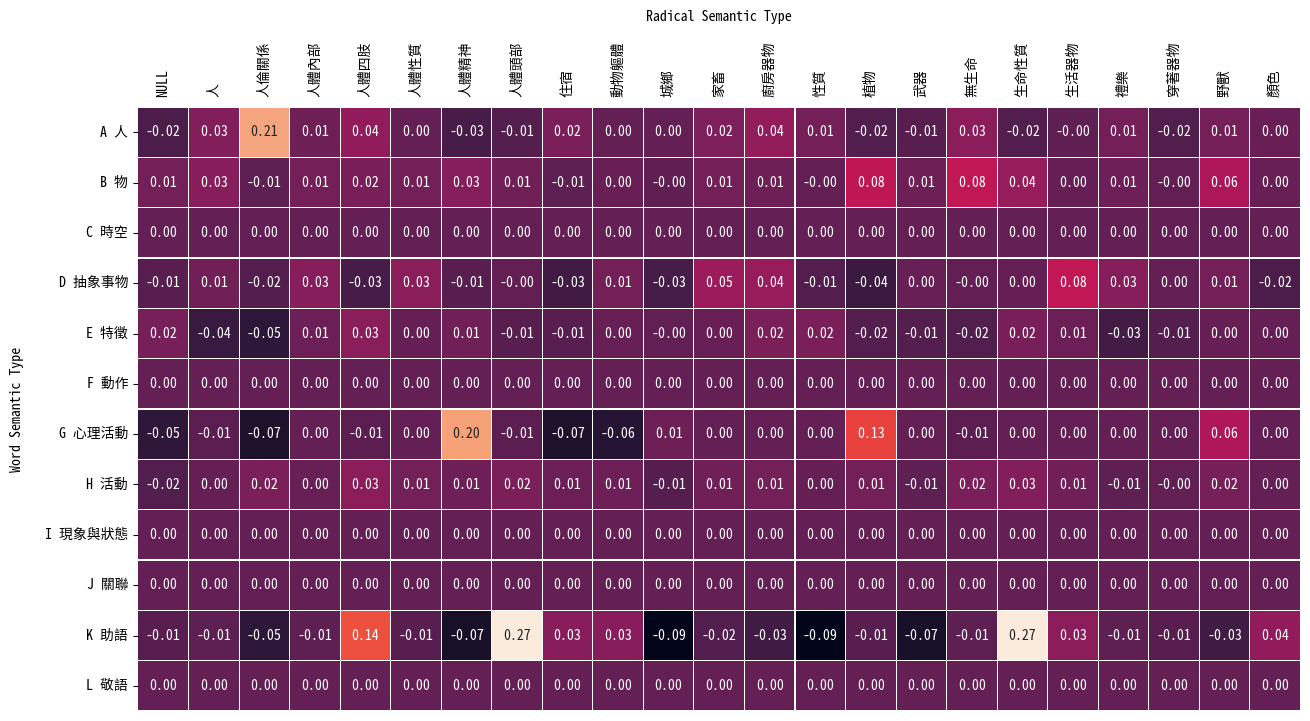

In [22]:
plt.figure(figsize=(15, 8), dpi=100)

dfT = df.T
dfT.rename(index={x: x.split('_')[0] for x in dfT.index }, inplace=True)
heatmap(dfT)

## Two-Character Words

ToDo: filter features with a frequency threshold

In [23]:
def heatmap(mat):
    dfT = pd.DataFrame(mat, index=rows)
    # sns.heatmap(dfT.T)
    ax = sns.heatmap(dfT.T, xticklabels=True, #linewidths=0.00, linecolor='white', 
                     # cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05)
                    )
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)
    # plt.xticks(rotation=90, fontsize=8)
    # plt.show()

In [24]:
Tagger = RadicalSemanticTagger(all_words=all_words(), bigram=True, word_type="double")
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)

feat_fq = np.sum(DTM.count_mat, axis=0)

In [25]:
# plt.hist(, bins=500)
def top_feats(fq_thresh, return_idx=False):
    feats = []
    for i, fq in enumerate(feat_fq):
        if fq >= fq_thresh:
            if return_idx:
                feats.append(i)
            else:
                feats.append(DTM.features[i])
    return feats

top_feats(500)

['NULL_NULL',
 'NULL_人體四肢',
 'NULL_植物',
 'NULL_無生命',
 '人_無生命',
 '人體四肢_NULL',
 '人體四肢_人體四肢',
 '人體四肢_植物',
 '人體四肢_無生命',
 '人體頭部_無生命',
 '植物_植物',
 '植物_無生命',
 '無生命_NULL',
 '無生命_人體四肢',
 '無生命_人體頭部',
 '無生命_植物',
 '無生命_無生命',
 '生命性質_無生命']

### Naive Bayes Classifier

In [26]:
from sklearn.naive_bayes import MultinomialNB

DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['F 動作', 'J 關聯', 'L 敬語']


,precision,recall,f1-score,support
A 人,0.681818,0.416667,0.517241,36.000000
B 物,0.519608,0.736111,0.609195,72.000000
C 時空,0.500000,0.166667,0.250000,18.000000
D 抽象事物,0.222222,0.230769,0.226415,52.000000
E 特徵,0.311111,0.259259,0.282828,54.000000
F 動作,0.000000,0.000000,0.000000,17.000000
G 心理活動,0.384615,0.384615,0.384615,13.000000
H 活動,0.375758,0.696629,0.488189,89.000000
I 現象與狀態,0.250000,0.051282,0.085106,39.000000
J 關聯,0.000000,0.000000,0.000000,13.000000


#### Permutation Importance: Selecting Important Features

In [27]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': 'f1_weighted',
}
imps = permutation_importance(model, X_test, y_test, scoring=scoring, #'f1_micro',  #scoring, #['f1_micro', 'accuracy'],
                              n_repeats=8, n_jobs=-1, random_state=100)


importances = imps['f1']['importances_mean']
indices = np.argsort(importances)[::-1]

df_importance = []
# Print the feature ranking
# features = list(df_feat.columns)
for i in range(X_test.shape[1]):
    df_importance.append(
        ( 
          imps['accuracy']['importances_mean'][i],
          imps['f1']['importances_mean'][i],
          imps['precision']['importances_mean'][i],
          imps['recall']['importances_mean'][i],
        )
    )
df_importance = pd.DataFrame(df_importance, index=df_feat.columns, 
                             columns=['accuracy', 'f1', 'precision', 'recall'])

In [28]:
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')

In [29]:
idx = { x for x in top_feats(50, return_idx=False) if 'NULL' not in x }
idx = df_importance_selected.index.isin(idx)
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')
df_importance_selected = df_importance_selected[idx]
df_importance_selected

,accuracy,f1,precision,recall
人_人倫關係,0.000175,0.000311,0.002139,0.000175
人_人體四肢,0.004558,0.003542,0.005328,0.004558
人_住宿,0.001578,0.001355,0.004919,0.001578
人_城鄉,0.000351,0.000211,0.001332,0.000351
人_性質,0.001403,0.001367,0.001415,0.001403
...,...,...,...,...
野獸_植物,0.001928,0.002240,0.002487,0.001928
野獸_無生命,0.000526,0.000580,0.000681,0.000526
野獸_野獸,0.003506,0.004067,0.003523,0.003506
顏色_植物,0.000701,0.000759,0.000474,0.000701


#### Feature Importance of Each class

In [30]:
from copy import deepcopy

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = 20
)

# Base model
model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# print("Not predicted:", sorted(set(y_train) - set(predictions)))
scores = classification_report(y_test, predictions, pandas=False)
baseScore = deepcopy(scores)

In [31]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score

scoreDiff = {}
rmFeat = []
for col in df_importance_selected.index:
    # X_train_drop, X_test_drop = X_train.drop(columns=[col]), X_test.drop(columns=[col])
    # Shuffle
    X_train_drop, X_test_drop = X_train.copy(deep=True), X_test.copy(deep=True)
    X_train_drop[col] = X_train_drop[col].sample(frac=1, random_state=100).values
    X_test_drop[col] = X_test_drop[col].sample(frac=1, random_state=100).values
    # df1['HS_FIRST_NAME'] = df[4].sample(frac=1).values

    rmFeat.append(col)
    model = MultinomialNB(alpha=0.001)
    model.fit(X_train_drop, y_train)
    predictions = model.predict(X_test_drop)
    # print("Not predicted:", sorted(set(y_train) - set(predictions)))
    scores = classification_report(y_test, predictions, pandas=False)

    for cls, val in scores.items():
        # scoreDiff.setdefault(cls, [])
        if cls == 'accuracy':
            if 'accuracy' not in scoreDiff:
                scoreDiff['accuracy'] = []
            scoreDiff['accuracy'].append(baseScore['accuracy']- val)
        else:
            for stat, val in val.items():
                base_val = baseScore[cls][stat]
                k = f"{cls}_{stat}"
                if any(x in k for x in 'support macro weighted'.split()): continue
                if k not in scoreDiff:
                    scoreDiff[k] = []
                scoreDiff[k].append(base_val - val)

df = pd.DataFrame(scoreDiff, index=rmFeat)

In [32]:
DTM_all = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)
documents = [f"{x} {C.get_tag(x)}" for x in DTM_all.documents]
selected_feat_idx = [DTM_all.features.index(x) for x in df_importance_selected.index]
selected_feat_idx
count_mat = np.take(DTM_all.count_mat, selected_feat_idx, axis=1)

def heatmap2(mat):
    if isinstance(mat, np.ndarray):
        dfT = pd.DataFrame(mat, index=documents, columns=df_importance_selected.index)
    else:
        dfT = mat
        # dfT = df.filter(like='f1').T
        # dfT.rename(index={x: x.split('_')[0] for x in dfT.index }, inplace=True)
    ax = sns.heatmap(dfT, xticklabels=True, linewidths=0.01, linecolor='white', 
                     #annot=True, fmt='.2f', cbar=False,
                     cbar_kws=dict(orientation='horizontal', aspect=35, pad=0.05))
    ax.xaxis.set_label_position('top')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, 
                    bottom=False, top = False, labeltop=True)
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.xlabel("Radical Semantic Type", labelpad=15); plt.ylabel("Word Semantic Type", labelpad=15)
    plt.show()

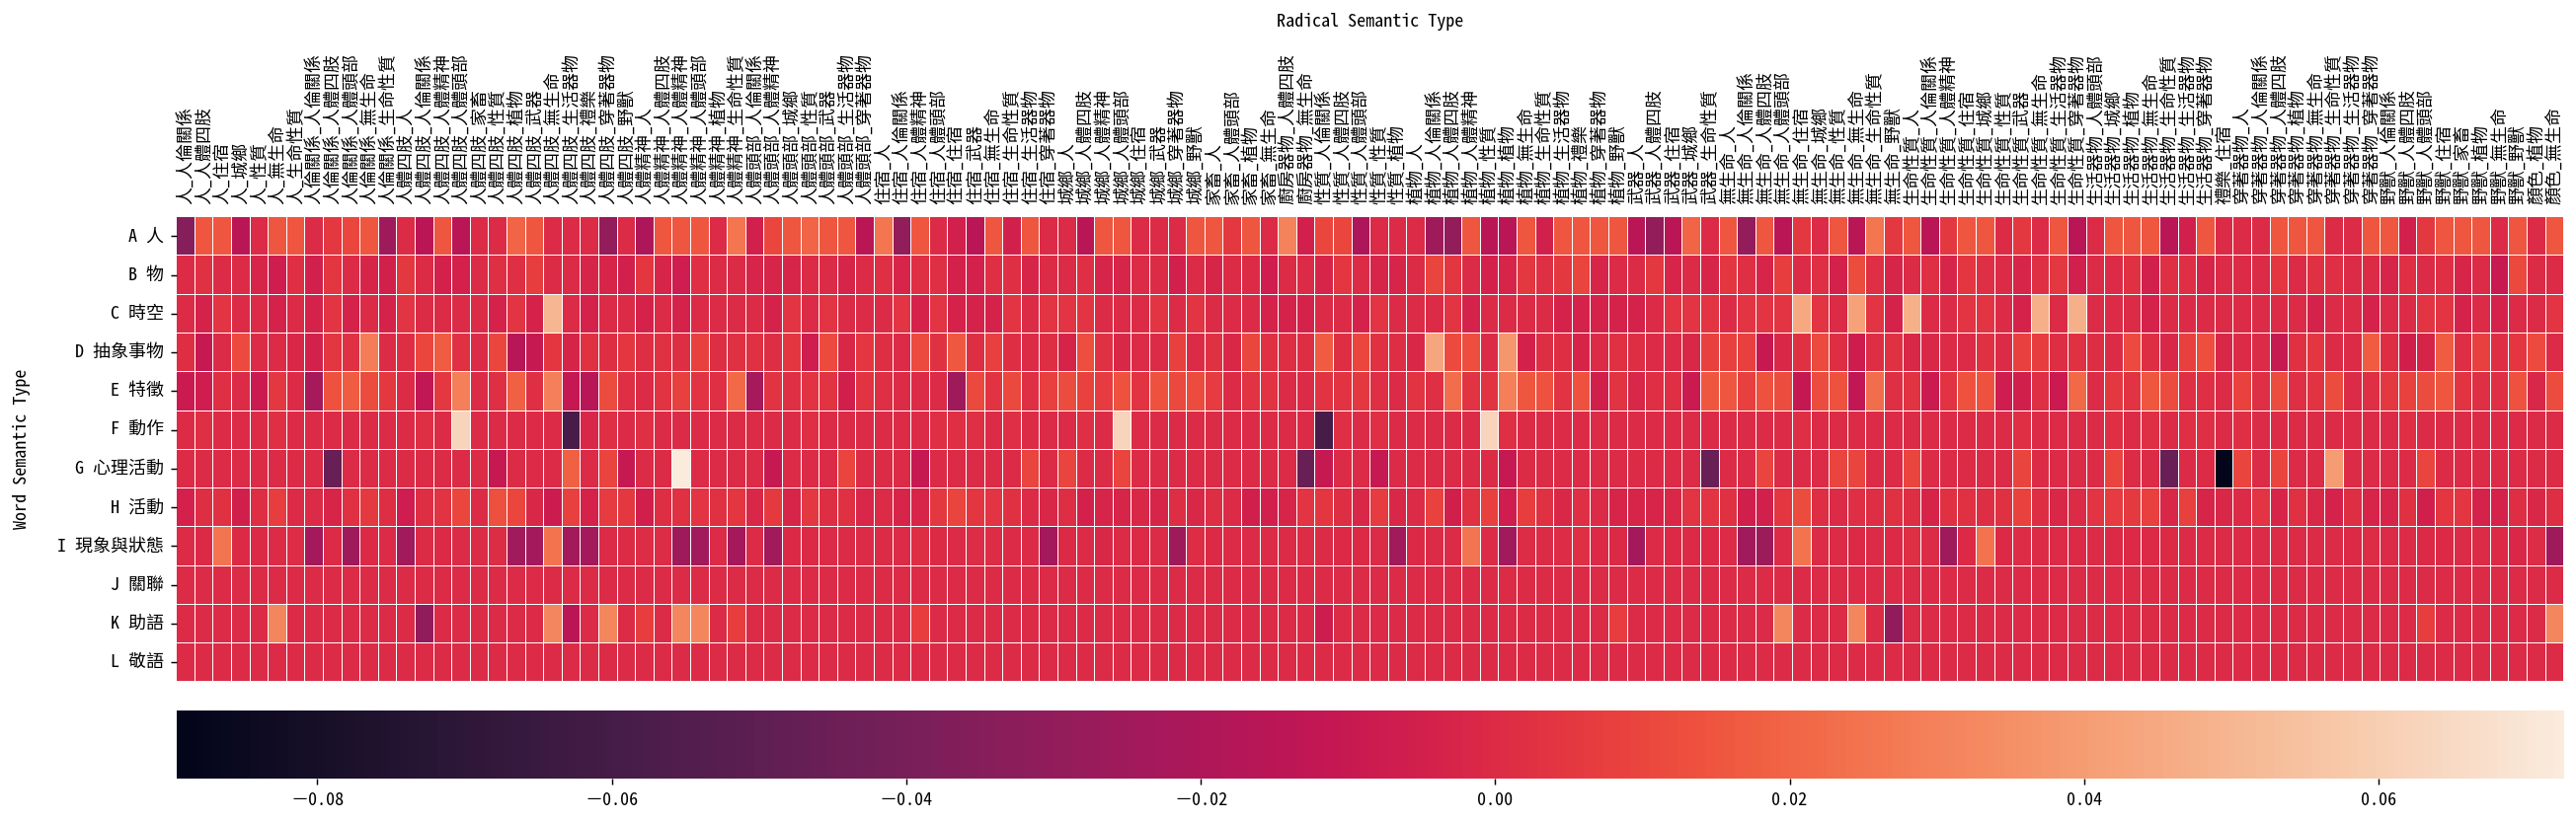

In [33]:
plt.figure(figsize=(24, 6), dpi=130)

dfT = df.filter(like='f1').T
dfT.rename(index={x: x.split('_')[0] for x in dfT.index }, inplace=True)
heatmap2(dfT)

In [34]:
Tagger = RadicalSemanticTagger(all_words=all_words(), bigram=True, word_type="double")

In [35]:
s1 = Tagger.tag2words.get('無生命_住宿')  # G: 無生命_人體精神  C: 人體四肢_無生命, 無生命_住宿   # F: 人體四肢_人體頭部, 城鄉_人體頭部 (drastic semantic change)
s2 = C.get_members('I')
s1.intersection(s2)

{'凌空',
 '填空',
 '墊底',
 '增容',
 '忽閃',
 '恢宏',
 '收尾',
 '改寫',
 '放寬',
 '放開',
 '散開',
 '昏厥',
 '暈厥',
 '暴富',
 '決定',
 '沉底',
 '泄密',
 '泄底',
 '泌尿',
 '煞尾',
 '燎原',
 '鋪展',
 '露底'}

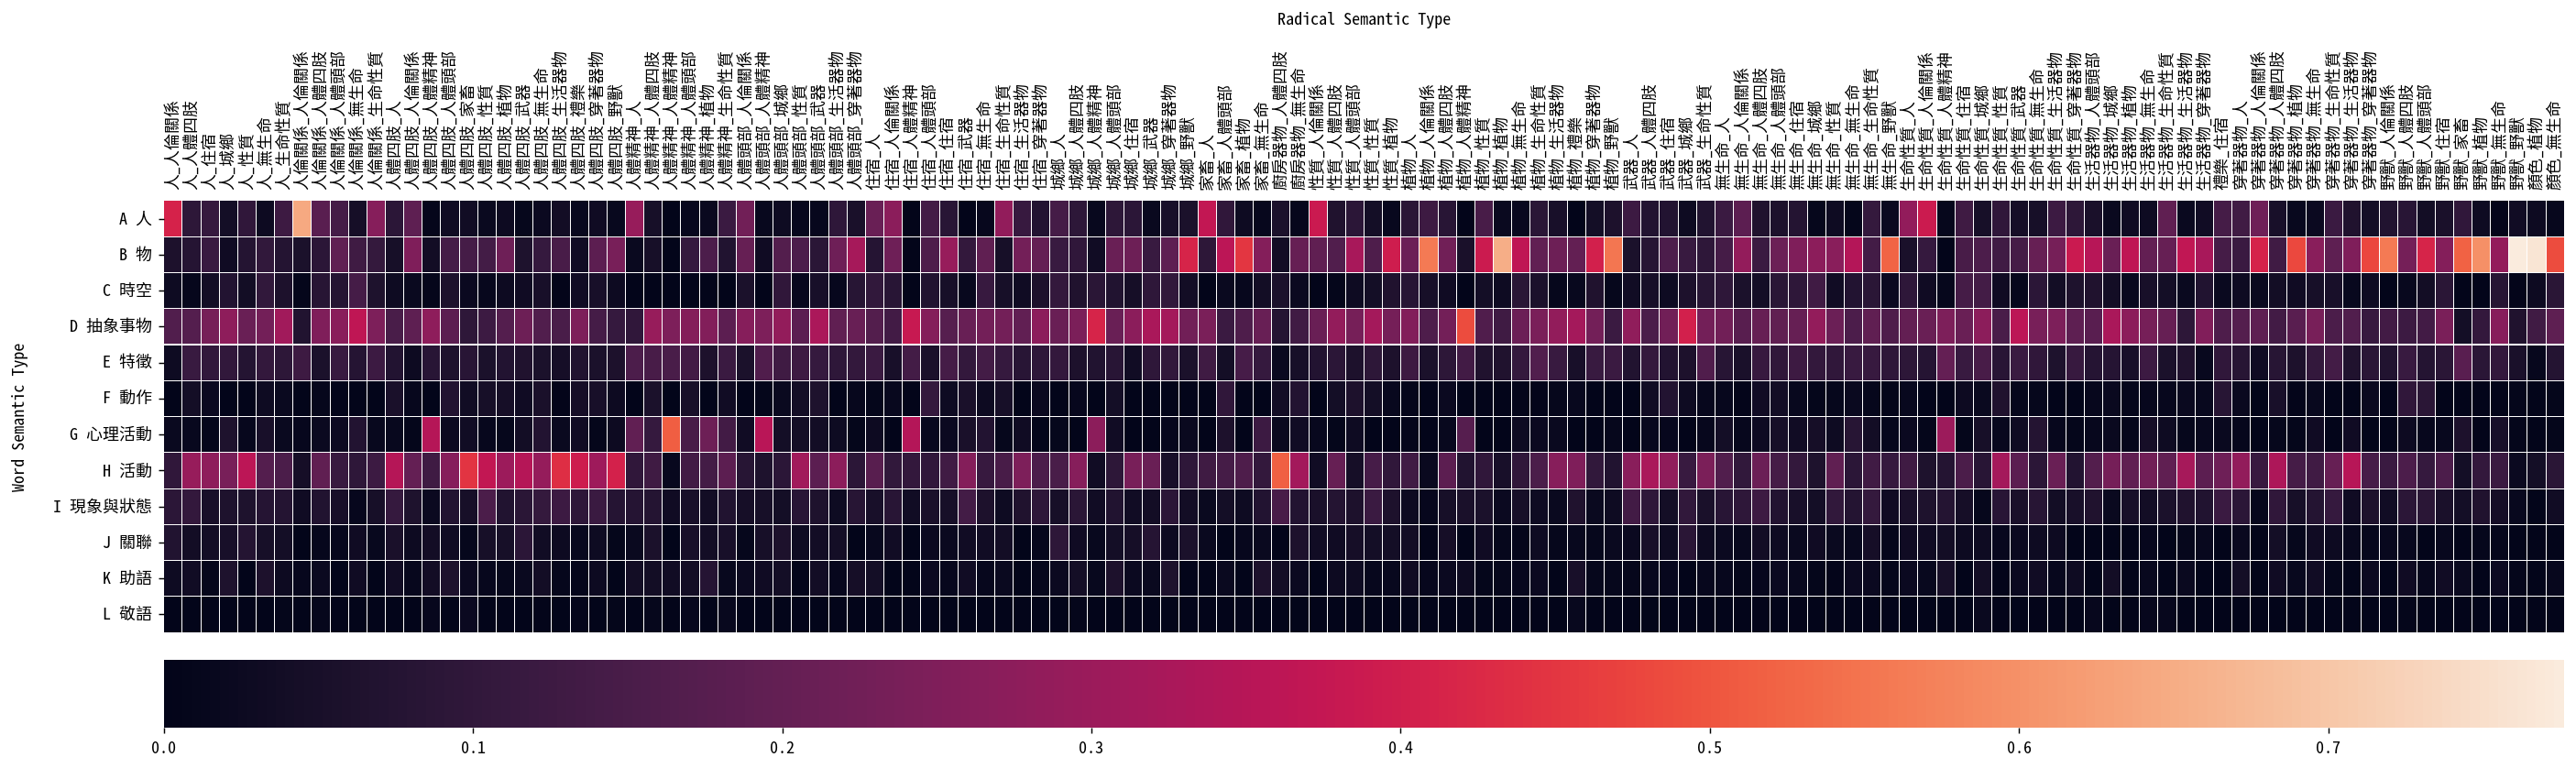

In [36]:
DTM_all = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=1)
selected_feat_idx = [DTM_all.features.index(x) for x in df_importance_selected.index]
selected_feat_idx
count_mat = np.take(DTM_all.count_mat, selected_feat_idx, axis=1)

plt.figure(figsize=(26, 6), dpi=130)
P_givenFeat = count_mat / np.sum(count_mat, axis=0)
heatmap2(P_givenFeat)

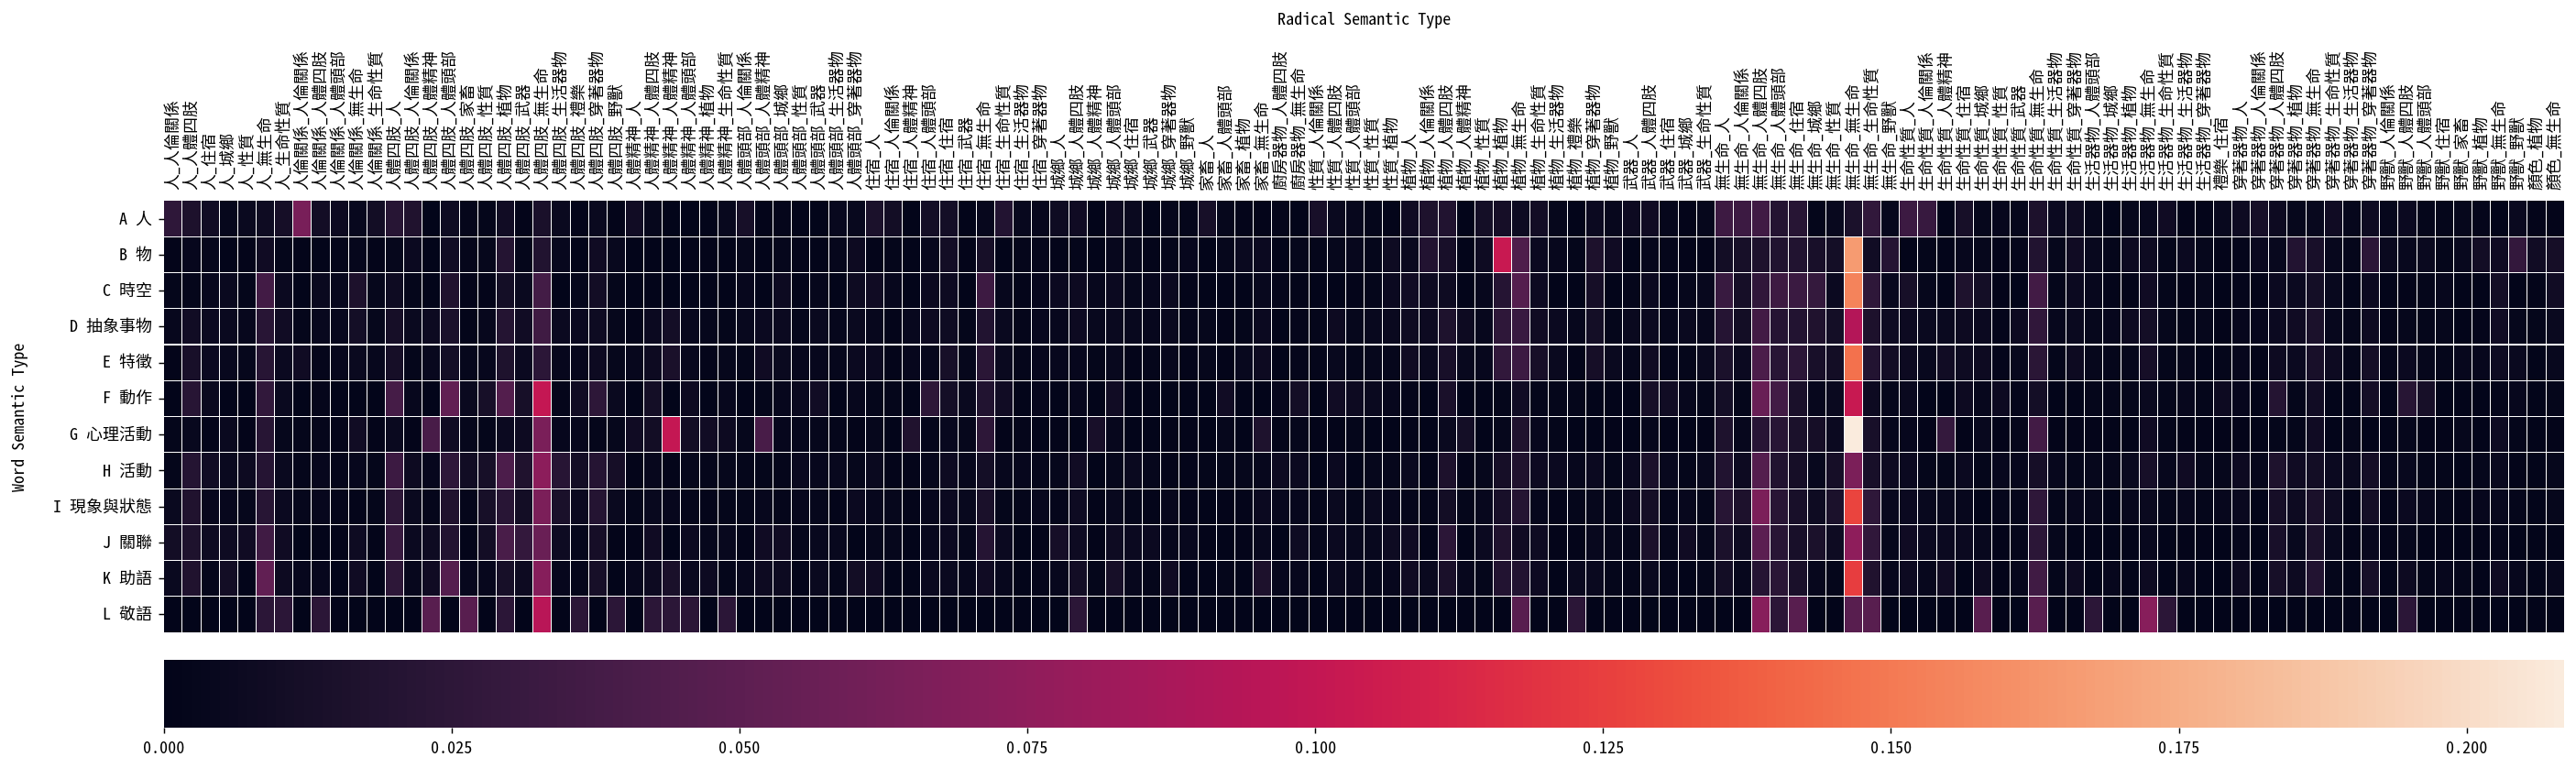

In [37]:
plt.figure(figsize=(26, 6), dpi=130)
P_givenDoc = (count_mat.T / np.sum(count_mat, axis=1)).T
heatmap2(P_givenDoc)

### Refit model with Top-296 important features (Model Checking)

Top-296 features should have a similar performance to the full model

In [38]:
df_importance_selected = df_importance[df_importance > 0].dropna(axis=0, how='any')
df_importance_selected

,accuracy,f1,precision,recall
NULL_NULL,0.002279,0.001369,0.004615,0.002279
NULL_人,0.001227,0.000728,0.003130,0.001227
NULL_人倫關係,0.000701,0.001078,0.001959,0.000701
NULL_人體內部,0.001578,0.001422,0.003896,0.001578
NULL_人體四肢,0.001578,0.001672,0.004504,0.001578
...,...,...,...,...
顏色_生命性質,0.000701,0.000702,0.000374,0.000701
顏色_生活器物,0.001753,0.001589,0.001519,0.001753
顏色_禮樂,0.001227,0.001213,0.000438,0.001227
顏色_野獸,0.001052,0.001213,0.001042,0.001052


In [39]:
from random import sample, seed

seed(10)

rnd_acc_546feat, rnd_acc_314feat, rnd_acc_165feat, rnd_acc_rnd165feat = [], [], [], []
rnd_f1_546feat, rnd_f1_314feat, rnd_f1_165feat, rnd_f1_rnd165feat = [], [], [], []
acc_546feat, acc_314feat, acc_165feat, acc_rnd165feat = [], [], [], []
f1_546feat, f1_314feat, f1_165feat, f1_rnd165feat = [], [], [], []

sampled_feat = set(DTM.features) - set(df_importance_selected.index)  # sample(DTM.features, 114)
for i in range(150):
    df_feat, df_tgt = DTM.pd, DTM.df_tgt

    X_train, X_test, y_train, y_test = train_test_split(
        df_feat, df_tgt, tgt_col="lev1", test_size = 0.5, random_state = i
    )
    X_train_sm, X_test_sm = X_train[df_importance_selected.index], X_test[df_importance_selected.index]
    # X_train_sm2, X_test_sm2 = X_train[df_importance_selected2.index], X_test[df_importance_selected2.index]
    X_train_rnd, X_test_rnd = X_train[sampled_feat], X_test[sampled_feat]
    y_train_shuffle, y_test_shuffle = sample(y_train, len(y_train)),  sample(y_test, len(y_test))

    for xtrain, xtest, acc, f1, acc_rnd, f1_rnd in zip([X_train, X_train_sm, X_train_rnd], 
                                  [X_test, X_test_sm, X_test_rnd], 
                                  [acc_546feat, acc_165feat , acc_rnd165feat],
                                  [f1_546feat, f1_165feat, f1_rnd165feat],
                                  [rnd_acc_546feat, rnd_acc_165feat , rnd_acc_rnd165feat],
                                  [rnd_f1_546feat, rnd_f1_165feat, rnd_f1_rnd165feat]
                                  ):
        model = MultinomialNB(alpha=0.001)
        model.fit(xtrain, y_train)
        predictions = model.predict(xtest)
        acc.append(accuracy_score(y_test, predictions))
        f1.append(f1_score(y_test, predictions, average="weighted"))
        
        # model.fit(xtrain, y_train_shuffle)
        # predictions = model.predict(xtest)
        acc_rnd.append(accuracy_score(y_test_shuffle, predictions))
        f1_rnd.append(f1_score(y_test_shuffle, predictions, average="weighted"))

In [40]:
from statistics import stdev, median, mean

df = pd.DataFrame([
    ["523 feats (All)",          mean(acc_546feat),    stdev(acc_546feat),    mean(f1_546feat),    stdev(f1_546feat)],
    ["296 feats (Top)",          mean(acc_165feat),    stdev(acc_165feat),    mean(f1_165feat),    stdev(f1_165feat)],
    ["227 feats (Bottom)", mean(acc_rnd165feat), stdev(acc_rnd165feat), mean(f1_rnd165feat), stdev(f1_rnd165feat)],
], columns=['model', 'Acc.mean', 'Acc.std', 'F1.mean', 'F1.std' ])
df

,model,Acc.mean,Acc.std,F1.mean,F1.std
0,523 feats (All),0.396793,0.013960,0.358500,0.013268
1,296 feats (Top),0.378373,0.014184,0.323189,0.012530
2,227 feats (Bottom),0.320271,0.011604,0.266290,0.012058


In [41]:
# Random baseline (prediction labels shuffled)
df = pd.DataFrame([
    ["523 feats (All)",    mean(rnd_acc_546feat), stdev(rnd_acc_546feat), mean(rnd_f1_546feat), stdev(rnd_f1_546feat)],
    ["296 feats (Top)",    mean(rnd_acc_165feat), stdev(rnd_acc_165feat), mean(rnd_f1_165feat), stdev(rnd_f1_165feat)],
    ["227 feats (Bottom)", mean(rnd_acc_rnd165feat), stdev(rnd_acc_rnd165feat), mean(rnd_f1_rnd165feat), stdev(rnd_f1_rnd165feat)],
], columns=['model', 'Acc.mean', 'Acc.std', 'F1.mean', 'F1.std' ])
df

,model,Acc.mean,Acc.std,F1.mean,F1.std
0,523 feats (All),0.154923,0.011717,0.129377,0.010350
1,296 feats (Top),0.165404,0.013259,0.129338,0.011543
2,227 feats (Bottom),0.171014,0.013282,0.125368,0.010861
